# Graph Analysis Techniques without Feature Learning

# Recommendation with graphs

## Lab 3: Content Filtering

### Xavier Bresson  


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/03_Traditional_GML/03_recom'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd

In [2]:
# Load libraries

# Math
import numpy as np

# Import data
import scipy.io

# Visualization 
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time

# Import functions in lib folder
import sys
sys.path.insert(0, 'lib/')

# Import helper functions
%load_ext autoreload
%autoreload 2
from lib.utils import shrink
from lib.utils import graph_laplacian

# Import
import scipy.sparse.linalg
import time

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load graphs of rows/users and columns/movies
mat = scipy.io.loadmat('datasets/synthetic_netflix.mat')
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']
n,m = M.shape
print('n,m=',n,m)

Mgt = M # Ground truth
O = Otraining
M = O* Mgt
perc_obs_training = np.sum(Otraining)/(n*m)
print('perc_obs_training=',perc_obs_training)

n,m= 150 200
perc_obs_training= 0.03


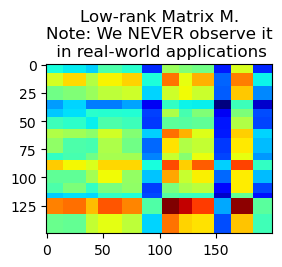

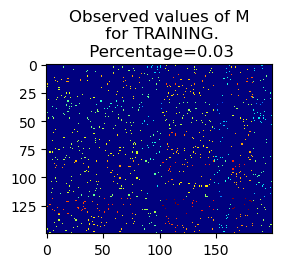

In [4]:
plt.figure(1)
plt.subplot(121).imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Low-rank Matrix M.\nNote: We NEVER observe it\n in real-world applications')
plt.show()

plt.subplot(122).imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M\n for TRAINING.\n Percentage=' + str(perc_obs_training))
plt.show()

<Figure size 640x480 with 0 Axes>

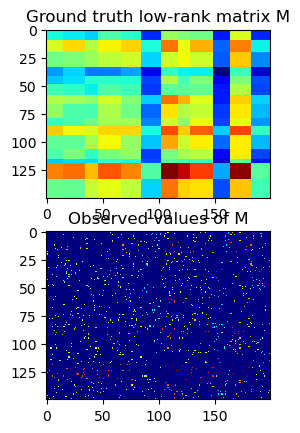

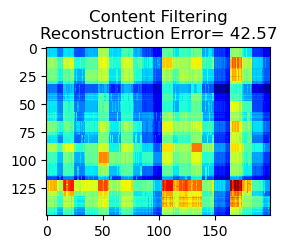

In [5]:
# Content Filtering / Graph Regularization by Dirichlet Energy

#Compute Graph Laplacians
Lr = graph_laplacian(Wrow)
Lc = graph_laplacian(Wcol)
I = scipy.sparse.identity(m, dtype=Lr.dtype)
Lr = scipy.sparse.kron( I, Lr )
Lr = scipy.sparse.csr_matrix(Lr)
I = scipy.sparse.identity(n, dtype=Lc.dtype)
Lc = scipy.sparse.kron( Lc, I )
Lc = scipy.sparse.csr_matrix(Lc)

# Regularization parameter
lambdaDir = 1e-2*8
lambdaDF = 1e3
alpha = 0.1

# Pre-processing
L = alpha* Lc + (1.-alpha)* Lr 
vecO = np.reshape(O.T,[-1]) 
vecO = scipy.sparse.diags(vecO, 0, shape=(n*m, n*m) ,dtype=L.dtype)
vecO = scipy.sparse.csr_matrix(vecO) 
At = lambdaDir* L + lambdaDF* vecO 
vecM = np.reshape(M.T,[-1])
bt = lambdaDF* scipy.sparse.csr_matrix( vecM ).T
bt = np.array(bt.todense()).squeeze()

# Solve by linear system
x,_ = scipy.sparse.linalg.cg(At, bt, x0=bt, tol=1e-9, maxiter=100)
X = np.reshape(x,[m,n]).T
 
# Reconstruction error
err_test = np.linalg.norm(Otest*(X-Mgt))

# Plot
fig = plt.figure(2)
fig.canvas.draw()
plt.show(block=False)
plt.subplot(221)
plt.imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Ground truth low-rank matrix M')
plt.subplot(223)
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M')
plt.show()
plt.subplot(224)
plt.imshow(X, interpolation='nearest', cmap='jet')
plt.title('Content Filtering\nReconstruction Error= '+ str(round(err_test,2)))
plt.show()
fig.canvas.draw()
time.sleep(0.01)